In [2]:
import tensorflow as tf
import os


dataset_dir = "C:/Users/loren/Downloads/archive/images/images" 


img_height = 224
img_width = 224
batch_size = 32


dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',                 # le etichette vengono dai nomi delle cartelle
    label_mode='int',                  # le etichette sono rappresentate da interi
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True                       # mescola le immagini prima di creare i batch
)


class_names = dataset.class_names 

# i rifiuti in metallo sono stati assegnati alla categoria indifferenziato

Found 15000 files belonging to 5 classes.


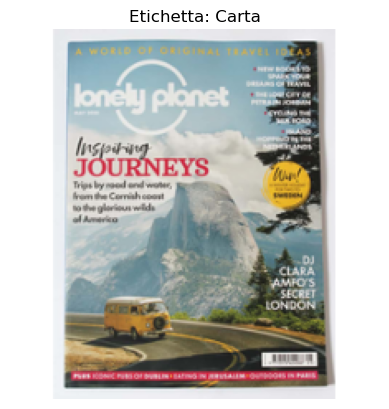

In [ ]:
import matplotlib.pyplot as plt

for images, labels in dataset.take(1): # prendo solo 1 batch di immagini
    plt.imshow(images[0].numpy())      # prendo prima immagine del batch e lo converto in un array visualizzabile da matplotlib
    plt.title(f"Etichetta: {class_names[labels[0]]}")
    plt.axis("off")
    plt.show()

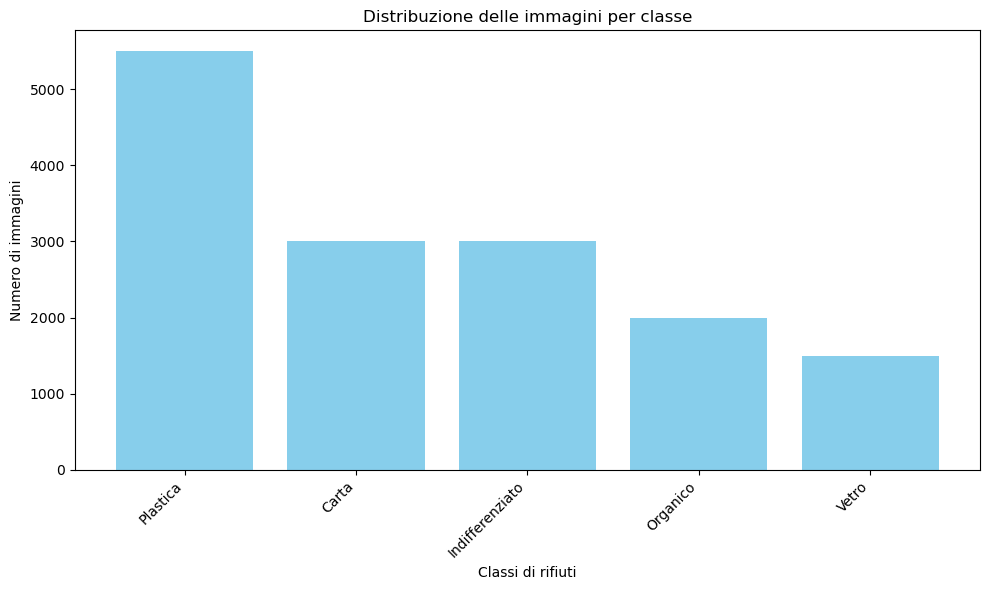

In [ ]:
### ANALISI ESPLORATIVA

# conto le immagini in ogni cartella principale, quindi x ogni classe
class_counts = {}

for class_name in os.listdir(dataset_dir): # scorro le sottocartelle
    class_path = os.path.join(dataset_dir, class_name) # creo il percorso ad esempio dataset/plastica 
    if os.path.isdir(class_path): # se esiste la cartella
        count = len([
            f for f in os.listdir(class_path)
            if f.lower().endswith(".png") and os.path.isfile(os.path.join(class_path, f)) # prendo solo i file che finiscono con .png 
        ])
        class_counts[class_name] = count # salvo nel dizionario per quella classe il numero di occorrenze

# ordina le classi per numero di immagini 
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[1], reverse=True))


plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Classi di rifiuti")
plt.ylabel("Numero di immagini")
plt.title("Distribuzione delle immagini per classe")
plt.tight_layout()
plt.show()


In [4]:
### Baseline

import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_score
import matplotlib.pyplot as plt


X = []
y = []
nome_classi = []

# Estrazione feature da ogni immagine. Ogni immagine diventa un vettore di 3 numeri 
for label, class_name in enumerate(sorted(os.listdir(dataset_dir))):
    class_path = os.path.join(dataset_dir, class_name) # contiene il percorso .../images/Plastica ecc
    if os.path.isdir(class_path):
        nome_classi.append(class_name)
        for file in os.listdir(class_path): # scorro le immagini per ogni sottocartella
            if file.lower().endswith(".png"): # controllo se è un immagine
                img_path = os.path.join(class_path, file) # percorso di ogni immagine
                try:
                    img = Image.open(img_path).resize((64, 64)).convert('RGB') # modelli di ml richiedono queste dimensioni
                    img = np.array(img)
                    mean_rgb = img.mean(axis=(0, 1)) # calcola la media dei colori rgb, ottengo un vettore a 3 valori
                    X.append(mean_rgb)
                    y.append(label)
                except Exception as e:
                    print(f"Errore con immagine {img_path}: {e}")


X = np.array(X) # contiene la media RGB per ogni immagine
y = np.array(y) # contiene le label (0,1,2,3,4)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Random Forest
rfc = RandomForestClassifier(n_estimators=100, random_state=42) # 100 alberi decisionali
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)


print(classification_report(y_test, y_pred, target_names=nome_classi))




                 precision    recall  f1-score   support

          Carta       0.61      0.57      0.59       600
Indifferenziato       0.65      0.59      0.62       600
       Organico       0.72      0.73      0.73       400
       Plastica       0.72      0.82      0.77      1100
          Vetro       0.69      0.56      0.62       300

       accuracy                           0.68      3000
      macro avg       0.68      0.65      0.66      3000
   weighted avg       0.68      0.68      0.68      3000



In [8]:
import tensorflow as tf


train_set = tf.keras.utils.image_dataset_from_directory( # creo dataset per tensorflow partendo da una cartella di immagini
    
    "C:/Users/loren/Downloads/archive/images/images",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(128,128),
    batch_size=32
)

val_set = tf.keras.utils.image_dataset_from_directory(
    "C:/Users/loren/Downloads/archive/images/images",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(128,128),
    batch_size=32
)

class_names = train_set.class_names


Found 15000 files belonging to 5 classes.
Using 12000 files for training.
Found 15000 files belonging to 5 classes.
Using 3000 files for validation.


In [ ]:
# Funzione di preprocessing
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # normalizzo, pixel tra 0 e 1
    return image, label                 

train_set = train_set.map(preprocess)
val_set=val_set.map(preprocess)

In [ ]:
# Controllo se train e test sono normalizzati 

for images, labels in train_set.take(1):
    print(f"Min pixel: {tf.reduce_min(images):.6f}")
    print(f"Max pixel: {tf.reduce_max(images):.6f}")
    print(f"Media pixel: {tf.reduce_mean(images):.6f}")
    
    if tf.reduce_max(images) <= 1.0:
        print("✅ GIÀ NORMALIZZATO (0-1)")
        print("❌ NON aggiungere Rescaling layer!")
    else:
        print("❌ NON NORMALIZZATO (0-255)")
        print("✅ Aggiungi normalizzazione")
    break

Min pixel: 0.000000
Max pixel: 1.000000
Media pixel: 0.713830
✅ GIÀ NORMALIZZATO (0-1)
❌ NON aggiungere Rescaling layer!


In [26]:
for images, labels in val_set.take(1):
    print(f"Min pixel: {tf.reduce_min(images):.6f}")
    print(f"Max pixel: {tf.reduce_max(images):.6f}")
    print(f"Media pixel: {tf.reduce_mean(images):.6f}")
    
    if tf.reduce_max(images) <= 1.0:
        print("✅ GIÀ NORMALIZZATO (0-1)")
        print("❌ NON aggiungere Rescaling layer!")
    else:
        print("❌ NON NORMALIZZATO (0-255)")
        print("✅ Aggiungi normalizzazione")
    break

Min pixel: 0.000000
Max pixel: 1.000000
Media pixel: 0.693500
✅ GIÀ NORMALIZZATO (0-1)
❌ NON aggiungere Rescaling layer!


In [ ]:
## Data augmentation

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1)
])

# applico al train set

AUTOTUNE = tf.data.AUTOTUNE

train_set = (
    train_set
    .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

modello = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)), # 32 filtri per rilevare caratteristiche semplici
        MaxPooling2D(2,2), # dimezza le dimensioni delle immagini (riduce complessità)

        Conv2D(64, (3,3), activation='relu'), # 64 filtri rilevano caratteristiche + complesse
        MaxPooling2D(2,2),
        
        Flatten(), # trasformo in un vettore 1-dim per poterlo passare al layer denso
        
        Dense(128, activation='relu'),
        Dropout(0.3),
        
        Dense(5, activation='softmax')
])

modello.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy', # ho etichette intere
        metrics=['accuracy']
    )


c:\Users\loren\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = modello.fit(train_set, validation_data=val_set, epochs=20)

Epoch 1/20


375/375 ━━━━━━━━━━━━━━━━━━━━ 126s 335ms/step - accuracy: 0.3973 - loss: 1.5287 - val_accuracy: 0.4647 - val_loss: 1.3389
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 105s 280ms/step - accuracy: 0.5148 - loss: 1.2290 - val_accuracy: 0.5200 - val_loss: 1.2513
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 103s 274ms/step - accuracy: 0.6273 - loss: 0.9747 - val_accuracy: 0.5800 - val_loss: 1.2615
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 103s 273ms/step - accuracy: 0.7152 - loss: 0.7605 - val_accuracy: 0.6097 - val_loss: 1.3937
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 103s 275ms/step - accuracy: 0.7859 - loss: 0.6133 - val_accuracy: 0.6127 - val_loss: 1.3670
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 103s 274ms/step - accuracy: 0.8150 - loss: 0.5462 - val_accuracy: 0.6403 - val_loss: 1.4144
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 272ms/step - accuracy: 0.8566 - loss: 0.4233 - val_accuracy: 0.6450 - val_loss: 1.6757
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 273ms/step - accuracy: 0.8691 - loss: 0.41

In [ ]:
## Migliore val accuracy = 0.6933

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_model(num_classes, filtri, unita_dense, dropout, learning_rate):
    model = Sequential([

        Conv2D(filtri, (3,3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D(),
        Flatten(),
        Dense(unita_dense, activation='relu'),
        Dropout(dropout),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
import optuna
from tensorflow.keras.callbacks import EarlyStopping

def tuning(modelli):
    # iperparametri
    filtri = modelli.suggest_categorical("filtri", [32, 64, 128]) # per provare diversi numeri di filtri
    num_unita_dense = modelli.suggest_categorical("unità_dense", [64, 128])
    dropout = modelli.suggest_categorical("dropout", [0.2, 0.3]) # prova valori di dropout 0.2 e 0.3
    learning_rate = modelli.suggest_float("lr", 0.00001, 0.01, log=True) # prova valori tra i due estremi

    model = create_model(
        num_classes=5,
        filtri=filtri,
        unita_dense=num_unita_dense,
        dropout=dropout,
        learning_rate=learning_rate
    )

    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=2,    
        restore_best_weights=True
    )

    history = model.fit(train_set, validation_data=val_set, callbacks=[early_stop], epochs=5)  # poche epoche per tuning veloce

    val_accuracy = history.history['val_accuracy'][-1] # accuracy sull ultima epoca del val set
    return val_accuracy  # optuna cerca di massimizzare questo valore

In [ ]:
study = optuna.create_study(direction="maximize") # l'obiettivo è massimizzare val_accuracy
study.optimize(tuning, n_trials=20)  # chiama la funzione 20 volte con diverse combinazioni di parametri

# optuna restituisce la combinazione di iperparametri che ha dato il miglior risultato (massima val_accuracy)

[I 2025-07-30 18:28:46,640] A new study created in memory with name: no-name-d36e83d2-c48d-4e79-a85f-3d2ae173165d


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 269s 711ms/step - accuracy: 0.3475 - loss: 24.3576 - val_accuracy: 0.3697 - val_loss: 1.6059
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 242s 645ms/step - accuracy: 0.3654 - loss: 1.6055 - val_accuracy: 0.3697 - val_loss: 1.6044
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 241s 642ms/step - accuracy: 0.3639 - loss: 1.6031 - val_accuracy: 0.3697 - val_loss: 1.6018


[I 2025-07-30 18:41:19,008] Trial 0 finished with value: 0.3696666657924652 and parameters: {'filtri': 64, 'unità_dense': 128, 'dropout': 0.3, 'lr': 2.6452585140733684e-05}. Best is trial 0 with value: 0.3696666657924652.


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 450s 1s/step - accuracy: 0.3381 - loss: 249.3086 - val_accuracy: 0.3693 - val_loss: 1.5965
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 480s 1s/step - accuracy: 0.3640 - loss: 1.5901 - val_accuracy: 0.3693 - val_loss: 1.5817
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 535s 1s/step - accuracy: 0.3644 - loss: 1.5746 - val_accuracy: 0.3693 - val_loss: 1.5687


[I 2025-07-30 19:05:45,097] Trial 1 finished with value: 0.36933332681655884 and parameters: {'filtri': 128, 'unità_dense': 128, 'dropout': 0.2, 'lr': 0.00018216978440881265}. Best is trial 0 with value: 0.3696666657924652.


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 311s 777ms/step - accuracy: 0.3172 - loss: 128.0532 - val_accuracy: 0.3703 - val_loss: 1.6013
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 288s 768ms/step - accuracy: 0.3665 - loss: 1.5890 - val_accuracy: 0.3697 - val_loss: 1.5779
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 292s 779ms/step - accuracy: 0.3644 - loss: 1.5730 - val_accuracy: 0.3697 - val_loss: 1.5640


[I 2025-07-30 19:20:37,874] Trial 2 finished with value: 0.3696666657924652 and parameters: {'filtri': 32, 'unità_dense': 128, 'dropout': 0.3, 'lr': 0.00020310208160343403}. Best is trial 0 with value: 0.3696666657924652.


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 430s 1s/step - accuracy: 0.3313 - loss: 37.9749 - val_accuracy: 0.3697 - val_loss: 1.5995
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 129s 343ms/step - accuracy: 0.3639 - loss: 1.5960 - val_accuracy: 0.3690 - val_loss: 1.5883
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 126s 336ms/step - accuracy: 0.3635 - loss: 1.5845 - val_accuracy: 0.3693 - val_loss: 1.5781


[I 2025-07-30 19:32:03,391] Trial 3 finished with value: 0.36933332681655884 and parameters: {'filtri': 32, 'unità_dense': 128, 'dropout': 0.2, 'lr': 0.00012916685038425482}. Best is trial 0 with value: 0.3696666657924652.


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 161s 426ms/step - accuracy: 0.3216 - loss: 604.2093 - val_accuracy: 0.3697 - val_loss: 1.5282
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 158s 421ms/step - accuracy: 0.3639 - loss: 1.5194 - val_accuracy: 0.3697 - val_loss: 1.5145
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 163s 435ms/step - accuracy: 0.3629 - loss: 1.5108 - val_accuracy: 0.3697 - val_loss: 1.5140


[I 2025-07-30 19:40:05,516] Trial 4 finished with value: 0.3696666657924652 and parameters: {'filtri': 64, 'unità_dense': 64, 'dropout': 0.2, 'lr': 0.0019043515558772534}. Best is trial 0 with value: 0.3696666657924652.


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 229s 609ms/step - accuracy: 0.3436 - loss: 1600.7758 - val_accuracy: 0.3733 - val_loss: 1.5119
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 223s 595ms/step - accuracy: 0.3722 - loss: 1.5042 - val_accuracy: 0.3740 - val_loss: 1.5209
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 224s 598ms/step - accuracy: 0.3782 - loss: 1.5231 - val_accuracy: 0.3780 - val_loss: 1.5132
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 227s 605ms/step - accuracy: 0.3855 - loss: 1.4812 - val_accuracy: 0.3947 - val_loss: 1.5389
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 228s 607ms/step - accuracy: 0.3957 - loss: 1.4596 - val_accuracy: 0.3920 - val_loss: 1.6149


[I 2025-07-30 19:58:56,763] Trial 5 finished with value: 0.3919999897480011 and parameters: {'filtri': 64, 'unità_dense': 128, 'dropout': 0.2, 'lr': 0.009326140562869284}. Best is trial 5 with value: 0.3919999897480011.


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 101s 266ms/step - accuracy: 0.3445 - loss: 423.9055 - val_accuracy: 0.3697 - val_loss: 1.5765
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 95s 254ms/step - accuracy: 0.3640 - loss: 1.5681 - val_accuracy: 0.3697 - val_loss: 1.5506
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 95s 254ms/step - accuracy: 0.3629 - loss: 1.5443 - val_accuracy: 0.3697 - val_loss: 1.5341


[I 2025-07-30 20:03:48,042] Trial 6 finished with value: 0.3696666657924652 and parameters: {'filtri': 32, 'unità_dense': 64, 'dropout': 0.2, 'lr': 0.00043635772924847997}. Best is trial 5 with value: 0.3919999897480011.


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 128s 334ms/step - accuracy: 0.3345 - loss: 52.6903 - val_accuracy: 0.3697 - val_loss: 1.6026
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 125s 334ms/step - accuracy: 0.3657 - loss: 1.5998 - val_accuracy: 0.3697 - val_loss: 1.5944
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 127s 337ms/step - accuracy: 0.3633 - loss: 1.5895 - val_accuracy: 0.3697 - val_loss: 1.5878


[I 2025-07-30 20:10:07,901] Trial 7 finished with value: 0.3696666657924652 and parameters: {'filtri': 32, 'unità_dense': 128, 'dropout': 0.3, 'lr': 8.191789716585615e-05}. Best is trial 5 with value: 0.3919999897480011.


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 97s 252ms/step - accuracy: 0.3473 - loss: 260.5987 - val_accuracy: 0.3697 - val_loss: 1.5629
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 92s 246ms/step - accuracy: 0.3631 - loss: 1.5530 - val_accuracy: 0.3697 - val_loss: 1.5344
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 92s 245ms/step - accuracy: 0.3639 - loss: 1.5301 - val_accuracy: 0.3697 - val_loss: 1.5213


[I 2025-07-30 20:14:49,424] Trial 8 finished with value: 0.3696666657924652 and parameters: {'filtri': 32, 'unità_dense': 64, 'dropout': 0.3, 'lr': 0.0006620617382517312}. Best is trial 5 with value: 0.3919999897480011.


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 91s 238ms/step - accuracy: 0.3121 - loss: 109.7424 - val_accuracy: 0.3697 - val_loss: 1.5886
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 88s 235ms/step - accuracy: 0.3657 - loss: 1.5820 - val_accuracy: 0.3697 - val_loss: 1.5735
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 89s 238ms/step - accuracy: 0.3634 - loss: 1.5684 - val_accuracy: 0.3697 - val_loss: 1.5587


[I 2025-07-30 20:19:18,613] Trial 9 finished with value: 0.3696666657924652 and parameters: {'filtri': 32, 'unità_dense': 64, 'dropout': 0.2, 'lr': 0.00023096585383111708}. Best is trial 5 with value: 0.3919999897480011.


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 242s 640ms/step - accuracy: 0.3303 - loss: 3538.3840 - val_accuracy: 0.3903 - val_loss: 1.4832
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 231s 617ms/step - accuracy: 0.3984 - loss: 1.4582 - val_accuracy: 0.4017 - val_loss: 1.4796
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 514s 1s/step - accuracy: 0.4134 - loss: 1.4269 - val_accuracy: 0.4003 - val_loss: 1.5413
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 236s 628ms/step - accuracy: 0.4132 - loss: 1.4580 - val_accuracy: 0.4067 - val_loss: 1.5443
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 233s 621ms/step - accuracy: 0.4177 - loss: 1.4288 - val_accuracy: 0.3997 - val_loss: 1.6531


[I 2025-07-30 20:43:34,864] Trial 10 finished with value: 0.3996666669845581 and parameters: {'filtri': 64, 'unità_dense': 128, 'dropout': 0.2, 'lr': 0.009302821982810607}. Best is trial 10 with value: 0.3996666669845581.


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 229s 605ms/step - accuracy: 0.3456 - loss: 2366.9690 - val_accuracy: 0.3823 - val_loss: 1.5006
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 229s 610ms/step - accuracy: 0.3821 - loss: 1.4904 - val_accuracy: 0.3847 - val_loss: 1.5085
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 227s 605ms/step - accuracy: 0.3905 - loss: 1.4729 - val_accuracy: 0.3887 - val_loss: 1.5231
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2611s 7s/step - accuracy: 0.4013 - loss: 1.4494 - val_accuracy: 0.3900 - val_loss: 1.5348
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 257s 611ms/step - accuracy: 0.4096 - loss: 1.4339 - val_accuracy: 0.3903 - val_loss: 1.5285


[I 2025-07-30 21:42:47,666] Trial 11 finished with value: 0.3903333246707916 and parameters: {'filtri': 64, 'unità_dense': 128, 'dropout': 0.2, 'lr': 0.009802875173554689}. Best is trial 10 with value: 0.3996666669845581.


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 221s 582ms/step - accuracy: 0.3549 - loss: 3178.4729 - val_accuracy: 0.3790 - val_loss: 1.4972
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 219s 585ms/step - accuracy: 0.3826 - loss: 1.4785 - val_accuracy: 0.3857 - val_loss: 1.4806
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 222s 591ms/step - accuracy: 0.3931 - loss: 1.4602 - val_accuracy: 0.3863 - val_loss: 1.4825
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 2223s 6s/step - accuracy: 0.4002 - loss: 1.4492 - val_accuracy: 0.3920 - val_loss: 1.4954
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 533s 1s/step - accuracy: 0.4066 - loss: 1.4298 - val_accuracy: 0.3963 - val_loss: 1.4863


[I 2025-07-30 22:39:46,008] Trial 12 finished with value: 0.39633333683013916 and parameters: {'filtri': 64, 'unità_dense': 128, 'dropout': 0.2, 'lr': 0.008668657201244096}. Best is trial 10 with value: 0.3996666669845581.


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 533s 1s/step - accuracy: 0.3360 - loss: 1152.0281 - val_accuracy: 0.4680 - val_loss: 1.7543
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 4167s 11s/step - accuracy: 0.5213 - loss: 1.4597 - val_accuracy: 0.5230 - val_loss: 1.6290
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 219s 583ms/step - accuracy: 0.6394 - loss: 1.0266 - val_accuracy: 0.5563 - val_loss: 1.6727
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 220s 587ms/step - accuracy: 0.7165 - loss: 0.7986 - val_accuracy: 0.5743 - val_loss: 1.7410
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 220s 588ms/step - accuracy: 0.7535 - loss: 0.7891 - val_accuracy: 0.5820 - val_loss: 1.8003


[I 2025-07-31 00:09:06,510] Trial 13 finished with value: 0.5820000171661377 and parameters: {'filtri': 64, 'unità_dense': 128, 'dropout': 0.2, 'lr': 0.0025336875696777964}. Best is trial 13 with value: 0.5820000171661377.


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 445s 1s/step - accuracy: 0.3345 - loss: 1847.9498 - val_accuracy: 0.3697 - val_loss: 1.5238
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 28165s 75s/step - accuracy: 0.3641 - loss: 1.5146 - val_accuracy: 0.3697 - val_loss: 1.5140
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 472s 1s/step - accuracy: 0.3647 - loss: 1.5113 - val_accuracy: 0.3697 - val_loss: 1.5142


[I 2025-07-31 08:13:49,147] Trial 14 finished with value: 0.3696666657924652 and parameters: {'filtri': 128, 'unità_dense': 128, 'dropout': 0.2, 'lr': 0.0024637700197436287}. Best is trial 13 with value: 0.5820000171661377.


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 226s 596ms/step - accuracy: 0.3516 - loss: 759.6530 - val_accuracy: 0.4830 - val_loss: 1.5177
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 225s 600ms/step - accuracy: 0.5371 - loss: 1.2656 - val_accuracy: 0.5407 - val_loss: 1.4734
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 230s 612ms/step - accuracy: 0.6480 - loss: 0.9579 - val_accuracy: 0.5517 - val_loss: 1.6338
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 253s 673ms/step - accuracy: 0.7077 - loss: 0.8050 - val_accuracy: 0.5667 - val_loss: 1.8047
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 230s 612ms/step - accuracy: 0.7420 - loss: 0.7574 - val_accuracy: 0.5720 - val_loss: 2.1107


[I 2025-07-31 08:33:12,761] Trial 15 finished with value: 0.5720000267028809 and parameters: {'filtri': 64, 'unità_dense': 128, 'dropout': 0.2, 'lr': 0.002577135077854853}. Best is trial 13 with value: 0.5820000171661377.


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 233s 615ms/step - accuracy: 0.3329 - loss: 887.9847 - val_accuracy: 0.4720 - val_loss: 1.6643
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 11984s 32s/step - accuracy: 0.5371 - loss: 1.3777 - val_accuracy: 0.5327 - val_loss: 1.5934
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 245s 652ms/step - accuracy: 0.6462 - loss: 1.0348 - val_accuracy: 0.5647 - val_loss: 1.6819
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 238s 635ms/step - accuracy: 0.7315 - loss: 0.7825 - val_accuracy: 0.5937 - val_loss: 1.7325
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 241s 642ms/step - accuracy: 0.7844 - loss: 0.6621 - val_accuracy: 0.6090 - val_loss: 2.0350


[I 2025-07-31 12:08:53,993] Trial 16 finished with value: 0.609000027179718 and parameters: {'filtri': 64, 'unità_dense': 128, 'dropout': 0.2, 'lr': 0.0021165555618121883}. Best is trial 16 with value: 0.609000027179718.


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 241s 635ms/step - accuracy: 0.3172 - loss: 581.2073 - val_accuracy: 0.3697 - val_loss: 1.5558
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 243s 649ms/step - accuracy: 0.3656 - loss: 1.5597 - val_accuracy: 0.3700 - val_loss: 1.5272
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 247s 658ms/step - accuracy: 0.3654 - loss: 1.5174 - val_accuracy: 0.3700 - val_loss: 1.5236
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 243s 647ms/step - accuracy: 0.3645 - loss: 1.5076 - val_accuracy: 0.3700 - val_loss: 1.5168


[I 2025-07-31 12:25:07,767] Trial 17 finished with value: 0.3700000047683716 and parameters: {'filtri': 64, 'unità_dense': 128, 'dropout': 0.2, 'lr': 0.0009576160515234485}. Best is trial 16 with value: 0.609000027179718.


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1717s 5s/step - accuracy: 0.3378 - loss: 1647.6649 - val_accuracy: 0.3883 - val_loss: 1.5273
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 308s 821ms/step - accuracy: 0.4042 - loss: 1.4735 - val_accuracy: 0.4107 - val_loss: 1.4563
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 315s 841ms/step - accuracy: 0.4500 - loss: 1.3628 - val_accuracy: 0.4360 - val_loss: 1.4351
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 309s 825ms/step - accuracy: 0.5005 - loss: 1.2900 - val_accuracy: 0.4750 - val_loss: 1.4552
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 509s 1s/step - accuracy: 0.5409 - loss: 1.1825 - val_accuracy: 0.4810 - val_loss: 1.6008


[I 2025-07-31 13:17:47,404] Trial 18 finished with value: 0.48100000619888306 and parameters: {'filtri': 128, 'unità_dense': 64, 'dropout': 0.3, 'lr': 0.0037067124141384068}. Best is trial 16 with value: 0.609000027179718.


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 227s 599ms/step - accuracy: 0.3376 - loss: 767.6837 - val_accuracy: 0.4237 - val_loss: 1.5255
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 223s 595ms/step - accuracy: 0.4683 - loss: 1.4362 - val_accuracy: 0.4687 - val_loss: 1.3664
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 224s 596ms/step - accuracy: 0.5413 - loss: 1.1638 - val_accuracy: 0.5040 - val_loss: 1.2991
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 224s 596ms/step - accuracy: 0.6117 - loss: 1.0285 - val_accuracy: 0.5457 - val_loss: 1.1739
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 225s 601ms/step - accuracy: 0.6570 - loss: 0.8910 - val_accuracy: 0.3700 - val_loss: 1.5428


[I 2025-07-31 13:36:30,382] Trial 19 finished with value: 0.3700000047683716 and parameters: {'filtri': 64, 'unità_dense': 128, 'dropout': 0.2, 'lr': 0.0012434697706958312}. Best is trial 16 with value: 0.609000027179718.


In [ ]:
# Trial 16 finished with value: 0.609000027179718 and parameters: {'filtri': 64, 'unità_dense': 128, 'dropout': 0.2, 'lr': 0.0021165555618121883}. 
# Best is trial 16 with value: 0.609000027179718.

In [ ]:
## Bilanciamento classi

import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_train = []

for images, labels in train_set:
    y_train.extend(labels.numpy()) # estraggo le etichette e le aggiungo a ytrain

y_train = np.array(y_train) # contiene le etichette


class_weights = compute_class_weight( # calcolo dei pesi. Classi + frequenti hanno peso + basso e viceversa
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = dict(enumerate(class_weights)) # dizionario perchè keras deve sapere che peso assegnare ad ogni classe
print(class_weights_dict)

{0: 0.9905076351630211, 1: 0.9933774834437086, 2: 1.5170670037926675, 3: 0.5465725347301298, 4: 2.0202020202020203}


In [ ]:
## provo CNN con parametri di tuning

regolarizzazione = tf.keras.regularizers.l2(0.001) 

new_model = Sequential([

        Conv2D(64, (3,3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D(),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=regolarizzazione),
        Dropout(0.2),
        Dense(5, activation='softmax')
    ])

new_model.compile(
        optimizer=Adam(learning_rate=0.0021165555618121883),
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )

early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=3,    
        restore_best_weights=True
    )

new_history = new_model.fit(train_set, validation_data=val_set, class_weight=class_weights_dict ,epochs=20)

Epoch 1/20


c:\Users\loren\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 310s 819ms/step - accuracy: 0.2682 - loss: 7.3679 - val_accuracy: 0.2840 - val_loss: 1.6732
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 299s 796ms/step - accuracy: 0.2461 - loss: 1.7225 - val_accuracy: 0.3420 - val_loss: 1.6880
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 318s 847ms/step - accuracy: 0.2642 - loss: 1.7062 - val_accuracy: 0.2233 - val_loss: 1.8846
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 325s 864ms/step - accuracy: 0.2741 - loss: 1.6935 - val_accuracy: 0.2760 - val_loss: 1.7477
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 322s 857ms/step - accuracy: 0.2929 - loss: 1.6742 - val_accuracy: 0.3177 - val_loss: 1.6280
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 322s 858ms/step - accuracy: 0.3014 - loss: 1.6458 - val_accuracy: 0.3737 - val_loss: 1.5514
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 984s 3s/step - accuracy: 0.2797 - loss: 1.6361 - val_accuracy: 0.2970 - val_loss: 1.6545
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 310s 826ms/step - accuracy: 0.2988 - loss: 1.6491 

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

resnet = ResNet50(weights="imagenet", include_top=False, input_shape=(128,128,3)) # creazione backbone
# con includetop = false rimuovo ultimo layer denso

regolarizzazione = tf.keras.regularizers.l2(0.001) 

modello_resnet=Sequential(
    [
        resnet,
        Flatten(), # trasforma le feature in vettore 1-dim per i layer densi
        Dense(128, activation="relu", kernel_regularizer=regolarizzazione),
        Dropout(0.5),
        Dense(5, activation="softmax")
    ]
)

for layer in modello_resnet.layers[-20:]:
  layer.trainable = True # i pesi degli ultimi 20 layer sono addestrabili, quindi vengono aggiornati durante l'addestramento

# gli altri strati rimangono congelati

modello_resnet.compile(
  optimizer=Adam(learning_rate=0.0001),
  loss="sparse_categorical_crossentropy",
  metrics=["accuracy"]
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True
)

early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=5,    
        restore_best_weights=True
    )

modello_resnet.fit(train_set, validation_data=val_set, callbacks=[early_stop, checkpoint], class_weight=class_weights_dict, epochs=20)

# val_accuracy: 0.8603

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4856 - loss: 1.6782

375/375 ━━━━━━━━━━━━━━━━━━━━ 1530s 4s/step - accuracy: 0.4859 - loss: 1.6772 - val_accuracy: 0.2933 - val_loss: 2.0220
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7233 - loss: 0.9497

375/375 ━━━━━━━━━━━━━━━━━━━━ 1426s 4s/step - accuracy: 0.7234 - loss: 0.9495 - val_accuracy: 0.6440 - val_loss: 1.3083
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7778 - loss: 0.8178

375/375 ━━━━━━━━━━━━━━━━━━━━ 1425s 4s/step - accuracy: 0.7778 - loss: 0.8177 - val_accuracy: 0.8110 - val_loss: 0.7985
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8097 - loss: 0.7239

375/375 ━━━━━━━━━━━━━━━━━━━━ 1423s 4s/step - accuracy: 0.8098 - loss: 0.7239 - val_accuracy: 0.8280 - val_loss: 0.7080
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1452s 4s/step - accuracy: 0.8409 - loss: 0.6510 - val_accuracy: 0.8057 - val_loss: 0.9234
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3368s 9s/step - accuracy: 0.8548 - loss: 0.6066 - val_accuracy: 0.8043 - val_loss: 0.8337
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1337s 4s/step - accuracy: 0.8581 - loss: 0.6007 - val_accuracy: 0.7923 - val_loss: 0.8539
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8803 - loss: 0.5188

375/375 ━━━━━━━━━━━━━━━━━━━━ 1418s 4s/step - accuracy: 0.8803 - loss: 0.5188 - val_accuracy: 0.8427 - val_loss: 0.7638
Epoch 9/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8861 - loss: 0.5041

375/375 ━━━━━━━━━━━━━━━━━━━━ 1467s 4s/step - accuracy: 0.8861 - loss: 0.5041 - val_accuracy: 0.8603 - val_loss: 0.6543
Epoch 10/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 5402s 14s/step - accuracy: 0.8990 - loss: 0.4587 - val_accuracy: 0.8423 - val_loss: 0.7405
Epoch 11/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2226s 6s/step - accuracy: 0.8995 - loss: 0.4447 - val_accuracy: 0.8227 - val_loss: 3.1935
Epoch 12/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1301s 3s/step - accuracy: 0.9065 - loss: 0.4402 - val_accuracy: 0.8320 - val_loss: 0.7979
Epoch 13/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1280s 3s/step - accuracy: 0.9021 - loss: 0.4428 - val_accuracy: 0.8027 - val_loss: 1.1021
Epoch 14/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1273s 3s/step - accuracy: 0.9139 - loss: 0.4044 - val_accuracy: 0.8200 - val_loss: 0.8933


In [28]:
## Metriche

import tensorflow as tf
import numpy as np

best_model = tf.keras.models.load_model("C:\\Users\\loren\\OneDrive\\Desktop\\best_model.h5")


y_true = [] # classi vere
y_pred = [] # classi previste

for images, labels in val_set:
    previsioni = best_model.predict(images) # contiene x ogni immagine un array con le prob. di appartenere a ciascuna classe
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(previsioni, axis=1))  # prendiamo la classe con prob. massima

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [31]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names))

                 precision    recall  f1-score   support

          Carta       0.79      0.90      0.84       577
Indifferenziato       0.85      0.83      0.84       584
       Organico       0.84      0.93      0.88       418
       Plastica       0.91      0.83      0.87      1109
          Vetro       0.89      0.86      0.87       312

       accuracy                           0.86      3000
      macro avg       0.86      0.87      0.86      3000
   weighted avg       0.86      0.86      0.86      3000



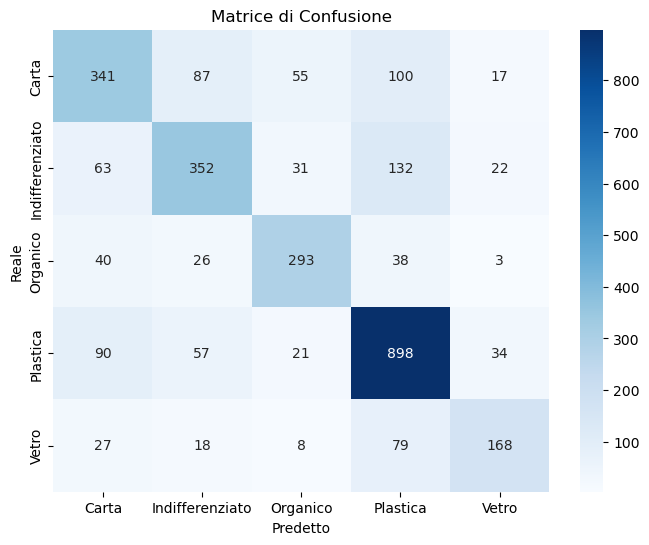

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=nome_classi, yticklabels=nome_classi)
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.title('Matrice di Confusione')
plt.show()
